# Perplexity Biomarker Score using N-gram Models
---

In [1]:
import pandas as pd
import numpy  as np
import os
import math
import random
import re

from collections   import defaultdict
from tqdm.notebook import tqdm
from time          import time

from typing import Optional, Iterable, Tuple, List, Set

import scipy.stats       as stats
import matplotlib.pyplot as plt

random.seed(0)

In [2]:
from utils.log_helpers     import *
from utils.evaluation      import *

In [3]:
import nltk
from nltk        import word_tokenize, pos_tag
from nltk.util   import ngrams
from nltk.corpus import stopwords

# One-time: make sure the resources exist (works on most NLTK versions)
def _ensure_nltk(universal=False):
    needed = {
        "tokenizers/punkt" : "punkt",
        "corpora/stopwords": "stopwords",
        # tagger names vary by version
    }
    
    for probe, pkg in needed.items():
        try: nltk.data.find(probe); print(f"{b(probe)} found")
        except LookupError: nltk.download(pkg, quiet=True); print(f"{b(probe)} downloaded from {b(pkg)}")
    
    # Try both tagger resource names
    for res in ("averaged_perceptron_tagger_eng","averaged_perceptron_tagger"):
        try: nltk.data.find(f"taggers/{res}"); break
        except LookupError:
            try: nltk.download(res, quiet=True)
            except: pass
    
    # Universal mapping (optional)
    if universal:
        try: nltk.data.find("taggers/universal_tagset")
        except LookupError:
            try: nltk.download("universal_tagset", quiet=True)
            except: pass

_ensure_nltk()

tokenizers/punkt found
corpora/stopwords found


# Constants

In [4]:
BASE = "../../../turn-taking"
TRANSCRIPTIONS = f"{BASE}/DementiaBank_Transcriptions"
MMSE_PATH      = f"{BASE}/temporal_biomarker/dx-mmse.csv"

START_TOKEN = "<START>"
END_TOKEN   = "<STOP>"

---

# Data Prep

In [5]:
def default_dict_entry(): return 0

def flatten(sents):
    """
    Flatten the sentences (a nested list) to a flat list (assuming the nesting level of 2..)
    """
    return [token for sent in sents for token in sent]

In [6]:
def prep_speech(df, pID, mmse_dx, min_length=3):
    """
    df      => pd.DataFrame: transcriptions
    mmse_dx => dict: {id: {"mmse": <val>, "dx": <val>}}
    """
    df = df.copy()
    df["Speech"] = df["Speech"].astype(str)
    
    # Get only the users speech
    user_only = df[(df["role"] == "user")]["Speech"].values
    user_rows = [str(row) for row in user_only if len(str(row).strip().split(" ")) > 3]
    
    # Each row is a sentence (or utterance)
    formatted_rows = []
    for utt in user_only:
        # Format it (if it is > the minimum length)
        if len(str(utt).strip().split(" ")) < min_length: continue # minimum length
        #sentence = [START_TOKEN] + [re.sub(r'[^\w]', '', w.lower()) for w in utt.split(" ")] + [END_TOKEN]
        sentence = [re.sub(r'[^\w]', '', w.lower()) for w in utt.split(" ")]
        
        # Create a DataFrame row
        formatted_rows.append({
            "pID" : pID,
            "dx"  : mmse_dx[pID]["dx"],
            "mmse": mmse_dx[pID]["mmse"],
            "text": " ".join(sentence),
        })
        
    return formatted_rows

In [7]:
# --------------------------------------------------------------------
# Load in the MMSE scores & pre the IDs
# --------------------------------------------------------------------
scores = pd.read_csv(MMSE_PATH)
scores = scores[["id", "mmse", "dx"]]

# Each id should be unique..
assert scores["id"].is_unique, "Duplicate ids found in scores"

# dict: {id: {"mmse": <val>, "dx": <val>}}
mmse_dx = scores.set_index("id")[["mmse", "dx"]].to_dict(orient="index")


# --------------------------------------------------------------------
# Prepare the transcriptions
# --------------------------------------------------------------------
# Load in the transcription files
t_files = [fname for fname in os.listdir(TRANSCRIPTIONS) if fname[-5:] == ".xlsx"]

formatted_rows = []
for fname in t_files:
    pID = fname.split(".")[0]
    if mmse_dx.get(pID, None) == None: continue
    
    # Load in the transcription & Get just the users utterances 
    txt = pd.read_excel(f"{TRANSCRIPTIONS}/{fname}")
    user_rows = prep_speech(txt, pID, mmse_dx)
    if len(user_rows) == 0: continue
    
    formatted_rows += user_rows

# Create a DataFrame
raw_df = pd.DataFrame(formatted_rows)
print(raw_df.shape)
raw_df.head(2)

(1518, 4)


,pID,dx,mmse,text
0,587-0,ProbableAD,19.0,this is the boy trying to get the cookie jar d...
1,587-0,ProbableAD,19.0,and hes going to fall off the ladder off there


---
# Prepare N-grams
I already added start tokens during pre-processing, so no need for them here.

## Processing sentences <small>(original words, POS, stop words, etc.)</small>

In [8]:
# ====================================================================
# Processing sentences (original words, POS, stop words, etc.)
# ====================================================================
def preprocess_data(
    data        : pd.DataFrame,
    vocabulary  : Optional[Set[str]] = None,
    
    # Mode controls 
    mode        : str           = "pos",   # Parts of speech or just words => "pos" or "word"
    tagset      : Optional[str] = None,    # None for PTB, "universal" for coarse tags
    keep_punct  : bool          = True,    # Drop punctuation tags by default in POS
    min_count   : int           = 3,       # Only used for WORD mode vocab build
    
    # N-gram padding controls
    ngram_n     : int  = 2,                # 3 for trigrams, etc.
    add_bos_eos : bool = True,
    bos_token   : str  = "<START>",
    eos_token   : str  = "<STOP>",
    unk_token   : str  = "<UNK>",
    
    # Stop words
    stop_mode    : Optional[str] = None,      # How to handle stopwords => None | "keep"
    stopword_lang: str           = "english",
    
) -> Tuple[List[List[str]], Set[str]]:
    """
    Convert a DataFrame with a "text" column into token sequences for n-gram training/eval.
    
    * In POS mode, words are POS-tagged, then we add boundary tokens AFTER tagging.
    
    * For n-gram order n, sequences are padded with (n-1) BOS tokens at the start and (n-1) EOS at the end.
    
    * Stopwords (if enabled for POS mode) are replaced with tags or kept as the original word.
        -  None  => default behavior; replace stop words with their POS tags.
        - "keep" => keep original stop words, replace all else (context words) with POS tags.
    
    * Vocabulary is built from the processed sequences (train) or reused (test). 
        - Out of vocabulary tokens are mapped to "<UNK>" (or whatever specified value).
    
    """
    # Tokenization: input is expected to already be space-tokenized
    texts     = data["text"].astype(str).tolist()
    sentences = [t.split(" ") for t in texts]
    
    # Prep for stop words
    if stop_mode == "keep": stop_set = set(stopwords.words(stopword_lang))

    # --------------------------------------------------------------------
    # Parts of speech tags
    # --------------------------------------------------------------------
    if mode == "pos":
        # Tag words first (this gives arrays of (word, tag))
        tagged_s = [pos_tag(seq, tagset=tagset) for seq in sentences]

        # Extract just the tag sequence & handle stop words
        if stop_mode == "keep": as_lists = [[(w if (w in stop_set) else t) for w, t in sent] for sent in tagged_s]
        else:                   as_lists = [[ t                            for _, t in sent] for sent in tagged_s]

    # --------------------------------------------------------------------
    # Original words from the transcript
    # --------------------------------------------------------------------
    else:
        # Minimal prep...
        as_lists = sentences
    
    
    # --------------------------------------------------------------------
    # Optionally drop punctuation tags (shouldn't ever be any)
    # --------------------------------------------------------------------
    if not keep_punct:
        if tagset == "universal":
            # In Universal tagset, punctuation is "."
            as_lists = [[t for t in sent if t != "."] for sent in as_lists]
        else:
            PUNCT_PTB = {".", ",", ":", "``", "''", "-LRB-", "-RRB$-", "-RRB-"}
            as_lists = [[t for t in sent if t not in PUNCT_PTB] for sent in as_lists]
    
    # --------------------------------------------------------------------
    # N-gram padding (beginning-of-sentence & ending-of-sentence)
    # --------------------------------------------------------------------
    # The number of tokens added depends on the planned n-gram
    if add_bos_eos and ngram_n >= 2:
        bos_pad  = [bos_token] * (ngram_n - 1)
        eos_pad  = [eos_token] * (ngram_n - 1)
        as_lists = [bos_pad + sent + eos_pad for sent in as_lists]
    
    # --------------------------------------------------------------------
    # Vocabulary
    # --------------------------------------------------------------------
    # If we need to create a new vocabulary...
    if vocabulary is None or len(vocabulary) == 0:
        # Count words (or tokens) as the occur
        freq = defaultdict(int)
        for sent in as_lists:
            for w in sent: freq[w] += 1

        # Only keep words that occur more than X times
        vocabulary = {w for w, c in freq.items() if c >= min_count}

    # Map out-of-vocabulary words to the unknown token
    as_lists = [[(w if (w in vocabulary) else unk_token) for w in sentence] for sentence in as_lists]
        
    # Return the prepared sentences and the vocabulary
    return as_lists, vocabulary


## Demonstrate the data processing

In [9]:
# Params
ngram_n =  2  # n-gram model size
s       = 22  # sentence index (0 is good but too long, 17 solid)

# --------------------------------------------------------------------
# Process with different params
# --------------------------------------------------------------------
s0, v0 = preprocess_data(raw_df, mode="word", ngram_n=ngram_n)
s1, v1 = preprocess_data(raw_df, mode="pos",  ngram_n=ngram_n)
s2, v2 = preprocess_data(raw_df, mode="pos",  ngram_n=ngram_n, stop_mode="keep")

print(f"{BOLD}{'Original Text:   '}{RESET} Num sentences: {len(s0):,}  Num vocabulary: {len(v0):3,}")
print(f"{BOLD}{'Parts-of-Speech: '}{RESET} Num sentences: {len(s1):,}  Num vocabulary: {len(v1):3,}")
print(f"{BOLD}{'POS & stop words:'}{RESET} Num sentences: {len(s2):,}  Num vocabulary: {len(v2):3,}\n\n")


# --------------------------------------------------------------------
# Show an example sentence
# --------------------------------------------------------------------
sR = ([""] * (ngram_n-1)) + list(raw_df["text"].iat[s].split(" ")) + ([""] * (ngram_n-1))
#strings = ["", "", "", ""]
strings = [
    f"{BOLD}Raw:              {RESET}", 
    f"{BOLD}Original Text:    {RESET}", 
    f"{BOLD}Parts-of-Speech:  {RESET}", 
    f"{BOLD}POS & stop words: {RESET}",
]

# Add words
for i in range(len(s0[s])):
    l0, l1, l2, l3 = sR[i], s0[s][i], s1[s][i], s2[s][i]
    length     = max([len(l0), len(l1), len(l2), len(l3)])
    
    strings[0] += f"{l0.ljust(length)} "
    strings[1] += f"{l1.ljust(length)} "
    strings[2] += f"{l2.ljust(length)} "
    strings[3] += f"{l3.ljust(length)} "
    
for l in strings: print(l)

Original Text:    Num sentences: 1,518  Num vocabulary: 496
Parts-of-Speech:  Num sentences: 1,518  Num vocabulary:  29
POS & stop words: Num sentences: 1,518  Num vocabulary: 122


Raw:                      a  window into another room         
Original Text:    <START> a  window into another <UNK> <STOP> 
Parts-of-Speech:  <START> DT NN     IN   DT      NN    <STOP> 
POS & stop words: <START> a  NN     into DT      NN    <STOP> 


---
# Perplexity Calculations

In [10]:
not_seen = 0
yes_seen = 0

# ====================================================================
# Implementing Laplace Smoothing
# ====================================================================
def smoothed_ln_probability(cfd_n_gram, n_gram, n, V, smoothing=False, laplace_smoothing_constant=1):
    """
    Old versions had the outer function calling the .freq method when there was no smoothing since
    that runs much faster. However, since we will pretty much always be smoothing, I just removed
    that part...
    """
    global not_seen
    global yes_seen
    
    # --------------------------------------------------------------------
    # Get counts and total possible outcomes (before smoothing)
    # --------------------------------------------------------------------
    # Unigram
    if n == 1: 
        count = cfd_n_gram[n_gram]
        total_possible_outcomes = sum(cfd_n_gram.values())
        
    elif n == 2: # Bigram
        count = cfd_n_gram[n_gram[0]][n_gram[1]]
        total_possible_outcomes = sum(cfd_n_gram[n_gram[0]].values())
        
    else: # All n-grams where n > 2
        n_gram_condition = tuple([word for word in n_gram[:-1]])
        count                   =     cfd_n_gram[n_gram_condition][n_gram[-1]]
        total_possible_outcomes = sum(cfd_n_gram[n_gram_condition].values())
        
    # --------------------------------------------------------------------
    # Adjust values if smoothing is enabled
    # --------------------------------------------------------------------
    if total_possible_outcomes == 0: not_seen += 1
    else:                            yes_seen += 1
    
    if smoothing:
        count = count + laplace_smoothing_constant
        total_possible_outcomes = total_possible_outcomes + (V * laplace_smoothing_constant)
    
    # Calculate final probability and ln probability
    if total_possible_outcomes == 0: probability = 0
    else:                            probability = count / total_possible_outcomes
    
    if probability > 0: ln_probability = math.log(probability)
    else:               ln_probability = 0.0
    
    return ln_probability


# ====================================================================
# Calculate Perplexity of test sentences, given training sentences
# ====================================================================
def calc_perplexity0(train_sentences, test_sentences, n, V, smoothing=False):
    """
    Calculate Perplexity of test sentences, given training sentences
    
    This treats sentences of different lengths equally, should test it the other way...
    
    """
    # --------------------------------------------------------------------
    # Create n-grams and ConditionalFreqDist
    # --------------------------------------------------------------------
    if n == 1: # Unigram
        train_n_gram_list = train_sentences 
        test_n_gram_list  = test_sentences
        cfd_n_gram = nltk.probability.FreqDist(flatten(train_sentences))
    else: 
        train_n_gram_list = [list(ngrams(x, n)) for x in train_sentences]
        test_n_gram_list  = [list(ngrams(x, n)) for x in  test_sentences]
        flattened = flatten(train_n_gram_list)
        
        if n == 2: cfd_n_gram = nltk.ConditionalFreqDist(flattened)
        else:
            tupled = [(n_gram[:-1], n_gram[-1]) for n_gram in flattened]
            cfd_n_gram = nltk.ConditionalFreqDist(tupled)

    # --------------------------------------------------------------------
    # Compute perplexity for each sentence separately, then compute average across all sentences
    # --------------------------------------------------------------------
    sentence_perplexities = []
    for n_grams in test_n_gram_list:
        sum_of_ln_probabilities = 0
        
        # Different ln_probability calculation depending on if we are smoothing or not
        for n_gram in n_grams:
            ln_probability = smoothed_ln_probability(cfd_n_gram, n_gram, n, V=V, smoothing=smoothing)
            sum_of_ln_probabilities += ln_probability
            
        # After calculating the ln_probabilities for all of the n_grams, we can calculate the sentence perplexity
        average     = sum_of_ln_probabilities / len(n_grams)
        exponential = math.exp(-average)
        sentence_perplexities.append(exponential)
        
    return sum(sentence_perplexities)/len(sentence_perplexities)




# ====================================================================
# Calculate Perplexity of test sentences, given training sentences
# ====================================================================
def calc_perplexity(train_sentences, test_sentences, n, V, smoothing=False):
    """
    Calculate Perplexity of test sentences, given training sentences
    
    This treats sentences of different lengths equally, should test it the other way...
    
    """
    # --------------------------------------------------------------------
    # Create n-grams and ConditionalFreqDist
    # --------------------------------------------------------------------
    if n == 1: # Unigram
        train_n_gram_list = train_sentences 
        test_n_gram_list  = test_sentences
        cfd_n_gram = nltk.probability.FreqDist(flatten(train_sentences))
    else: 
        train_n_gram_list = [list(ngrams(x, n)) for x in train_sentences]
        test_n_gram_list  = [list(ngrams(x, n)) for x in  test_sentences]
        flattened = flatten(train_n_gram_list)
        
        if n == 2: cfd_n_gram = nltk.ConditionalFreqDist(flattened)
        else:
            tupled = [(n_gram[:-1], n_gram[-1]) for n_gram in flattened]
            cfd_n_gram = nltk.ConditionalFreqDist(tupled)

    # --------------------------------------------------------------------
    # Compute perplexity for each sentence separately, then compute average across all sentences
    # --------------------------------------------------------------------
    sum_of_ln_probabilities = 0
    num_of_n_grams = 0
    
    for n_grams in test_n_gram_list:
        
        # Different ln_probability calculation depending on if we are smoothing or not
        for n_gram in n_grams:
            ln_probability = smoothed_ln_probability(cfd_n_gram, n_gram, n, V=V, smoothing=smoothing)
            sum_of_ln_probabilities += ln_probability
            num_of_n_grams          += 1
            
    # After calculating the ln_probabilities for all of the n_grams, we can calculate the sentence perplexity
    average     = sum_of_ln_probabilities / num_of_n_grams
    exponential = math.exp(-average)
    
    return exponential

---
# Finally, calculate perplexity
Two values for each ID (language models created excluding the specific pID):
* P_cn: Perplexity using the sentences from the Control group
* P_ad: Perplexity using the sentences from the ProbableAD group

In [11]:
def calc_lm_perplexity(
    sentences_df: pd.DataFrame, 
    pID         : str, 
    group       : str,           # "Control" | "ProbableAD"
    
    ngram_n : int  = 3,
    smooth  : bool = True,
    mode    : str  = "pos",
    stop_w  : str  = "keep",
):
    """
    Is kind of slow... we preprocess each time because of the vocabulary, but that step
    is only really needed for the words.
    
    # LM Control    => All sentences in the Control group
    # LM ProbableAD => All sentences in the ProbableAD group
    
    """
    # Split data
    s_df = sentences_df.copy()
    tr = s_df[(s_df["pID"] != pID) & (s_df["dx"] == group)].copy()
    ts = s_df[(s_df["pID"] == pID)                        ].copy()
    
    # Get sentences
    s_train, vocab = preprocess_data(tr, ngram_n=ngram_n, stop_mode=stop_w)
    s_test,  _     = preprocess_data(ts, ngram_n=ngram_n, stop_mode=stop_w, vocabulary=vocab)
    
    # Calculate perplexity
    perplexity = calc_perplexity(s_train, s_test, n=ngram_n, V=len(vocab)+1, smoothing=smooth)
    
    return perplexity


## Leave one out testing

In [12]:
NGRAM_N = 3
SMOOTH  = True
MODE    = "pos"
STOP_W  = "keep" # None "none" "keep"

not_seen = 0
yes_seen = 0

# ====================================================================
# Calculate two perplexity scores for each participant
# ====================================================================
s_df         = raw_df.copy()
pIDs         = list(s_df["pID"].unique())
progress_bar = tqdm(range(len(pIDs)), leave=True, position=0)
results      = []

ppl_args = dict(ngram_n=NGRAM_N, smooth=SMOOTH, mode=MODE, stop_w=STOP_W)

# --------------------------------------------------------------------
# Loop through each participant
# --------------------------------------------------------------------
t0 = time()
for pID in pIDs:
    # Calculate perplexity using both language models
    P_cn = calc_lm_perplexity(s_df, pID, "Control",    **ppl_args)
    P_ad = calc_lm_perplexity(s_df, pID, "ProbableAD", **ppl_args)

    # Book-keeping
    dx, mmse = mmse_dx[pID]["dx"], mmse_dx[pID]["mmse"]
    results.append({"pID": pID, "dx": dx, "mmse": mmse, "P_cn": P_cn, "P_ad": P_ad})
    progress_bar.update(1)

# --------------------------------------------------------------------
# Loop finished...
# --------------------------------------------------------------------
progress_bar.close()
t1 = time() - t0
print(f"Ran in: {format_time(t1)}")
    
# Turn into a DataFrame & add a perplexity difference column
ppl_df = pd.DataFrame(results)
ppl_df["P_diff"] = ppl_df["P_cn"] - ppl_df["P_ad"]

# Display
print(ppl_df.shape)
ppl_df.head(2)

  0%|          | 0/190 [00:00<?, ?it/s]

Ran in: 00:58
(190, 6)


,pID,dx,mmse,P_cn,P_ad,P_diff
0,587-0,ProbableAD,19.0,34.346545,30.404618,3.941926
1,293-1,ProbableAD,15.0,42.477319,34.372574,8.104745


In [13]:
print(f"Not seen: {not_seen:,}")
print(f"Yes seen: {yes_seen:,}")
print(f"Total:    {not_seen+yes_seen:,}")

Not seen: 3,250
Yes seen: 38,506
Total:    41,756


---
# Evaluate

────────────────────────────────────────────────────────────────────────────────────────────────────
Metric: P_cn  |  Outliers: trim
────────────────────────────────────────────────────────────────────────────────────────────────────
Control:     26.2710 (+/- 5.6870) | n =  72 ( 82)
ProbableAD:  33.7551 (+/- 8.9705) | n =  96 (108)
Diff:        -7.4841 | 95% CI [-9.6446, -5.3134]

Welch t p =  0.00000  |  Mann-Whitney p =  0.00000
Hedges  g = -0.96274  |  Cliff's      δ = -0.48756


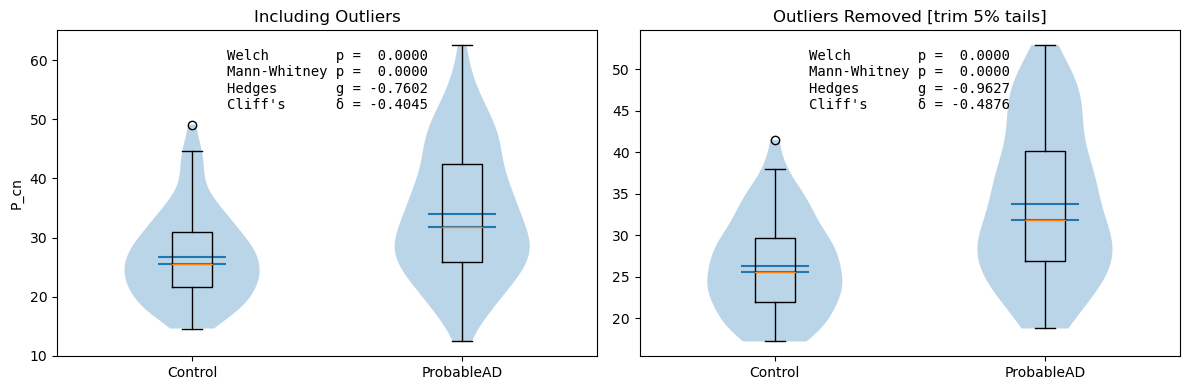

────────────────────────────────────────────────────────────────────────────────────────────────────
Metric: P_ad  |  Outliers: trim
────────────────────────────────────────────────────────────────────────────────────────────────────
Control:     29.1390 (+/- 5.4691) | n =  72 ( 82)
ProbableAD:  31.6616 (+/- 7.0412) | n =  96 (108)
Diff:        -2.5227 | 95% CI [-4.4607, -0.6814]

Welch t p =  0.00979  |  Mann-Whitney p =  0.02965
Hedges  g = -0.39140  |  Cliff's      δ = -0.19647


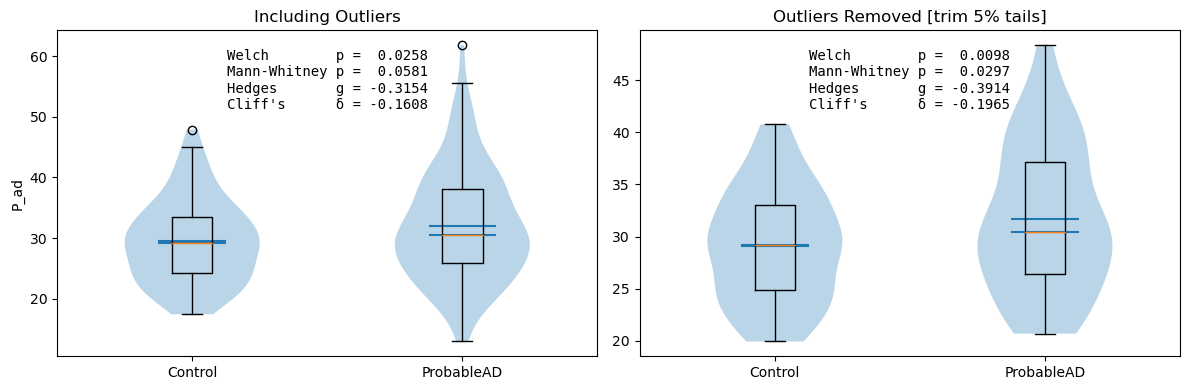

────────────────────────────────────────────────────────────────────────────────────────────────────
Metric: P_diff  |  Outliers: trim
────────────────────────────────────────────────────────────────────────────────────────────────────
Control:     -2.8802 (+/- 1.8613) | n =  72 ( 82)
ProbableAD:   1.6938 (+/- 3.2930) | n =  96 (108)
Diff:        -4.5739 | 95% CI [-5.3561, -3.8118]

Welch t p =  0.00000  |  Mann-Whitney p =  0.00000
Hedges  g = -1.64220  |  Cliff's      δ = -0.78472


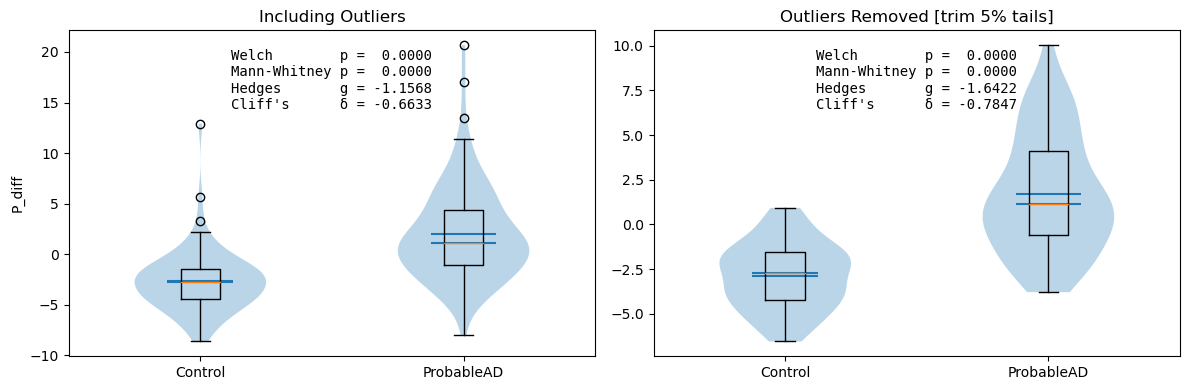

In [14]:
d0 = ppl_df.copy()


comp_args = dict(outliers="trim", trim_q=(0.05, 0.95), title_suffix="[trim 5% tails]")

x = compare_and_plot(d0, metric="P_cn",   **comp_args)
y = compare_and_plot(d0, metric="P_ad",   **comp_args)
z = compare_and_plot(d0, metric="P_diff", **comp_args)

---
# Plotting

In [15]:
# ======================================================================= ===================================
# Plotting
# ======================================================================= ===================================
# Small helpers
def _split_groups(df: pd.DataFrame, group_col: str = "dx", groups: Tuple[str, str] = ("Control", "ProbableAD")):
    cn = df[df[group_col] == groups[0]].copy()
    ad = df[df[group_col] == groups[1]].copy()
    return cn, ad

def _scatter_by_group(ax, df, x_col, y_col, alpha=0.5, groups=("Control", "ProbableAD")):
    cn, ad = _split_groups(df, groups=groups)
    ax.scatter(cn[x_col], cn[y_col], alpha=alpha, color="tab:blue",   label=groups[0])
    ax.scatter(ad[x_col], ad[y_col], alpha=alpha, color="tab:orange", label=groups[1])
    return cn, ad

def _fit_line(ax, x, y, *, color="black", ls="--", label_prefix="Both"):
    """Add a linear fit line; return r-value or np.nan if not enough points."""
    x = np.asarray(x); y = np.asarray(y)
    if x.size < 2 or y.size < 2: return np.nan
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    xs = np.sort(x)
    ax.plot(xs, slope * xs + intercept, color=color, linestyle=ls, label=f"{label_prefix} (r = {r_value:.4f})")
    return r_value


# =======================================================================
# Main plotting function
# =======================================================================
def plot_mmse_panels(
    d0              : pd.DataFrame,
    *,
    alpha           : float = 0.5,
    token_min       : int   = 50,
    ppl_max         : float = 150.0,
    anll_range      : Tuple[float, float] = (3.0, 5.5),
    groups          : Tuple[str, str] = ("Control", "ProbableAD"),
):
    """
    Three panels:
      (1) MMSE vs Perplexity (filtered: mmse notna, tokens > token_min, ppl < ppl_max)
      (2) MMSE vs Avg NLL    (filtered: mmse notna, tokens > token_min, anll in range)
      (3) Perplexity vs Tokens (full df)
    """
    # Print header
    print("─" * 100)
    print(f"{BOLD}Comparison Plots{RESET}")
    print("─" * 100)

    # Plot
    fig, axes = plt.subplots(4, 1, figsize=(12, 16))

    # Base filtered frame for panels 1 & 2
    base = d0[d0["mmse"].notna()].copy()

    # =======================================================================
    # 1) Perplexity
    # =======================================================================
    ax = axes[0]; y_col = "P_cn"
    
    d1 = base[base[y_col].notna()].copy()
    ad = d1[d1["dx"] == groups[1]]
    
    # Scatter & Fits (all + ProbableAD-only)
    _scatter_by_group(ax, d1, x_col=y_col, y_col="mmse", alpha=alpha, groups=groups)
    _fit_line(ax, d1[y_col].values, d1["mmse"].values, color="black",     ls="--", label_prefix="Both")
    _fit_line(ax, ad[y_col].values, ad["mmse"].values, color="indianred", ls=":",  label_prefix=f"ONLY {groups[1]}")

    # Labels
    ax.set_xlabel(y_col); ax.set_ylabel("MMSE")
    ax.set_title("Perplexity w/ Control")
    ax.legend(); ax.grid()

    # =======================================================================
    # 2) Average Negative Log-Likelihood
    # =======================================================================
    ax    = axes[1]; y_col = "P_ad"

    d2 = base[base[y_col].notna()].copy()
    ad = d2[d2["dx"] == groups[1]]
    
    # Scatter & Fits (all + ProbableAD-only)
    _scatter_by_group(ax, d2, x_col=y_col, y_col="mmse", alpha=alpha, groups=groups)
    _fit_line(ax, d2[y_col].values, d2["mmse"].values, color="black",     ls="--", label_prefix="Both")
    _fit_line(ax, ad[y_col].values, ad["mmse"].values, color="indianred", ls=":",  label_prefix=f"ONLY {groups[1]}")

    # Labels
    ax.set_xlabel(y_col); ax.set_ylabel("MMSE")
    ax.set_title("Perplexity w/ ProbableAD")
    ax.legend(); ax.grid()

    # =======================================================================
    # 3) Tokens & Perplexity (possible confound)
    # =======================================================================
    ax    = axes[2]; y_col = "P_diff"

    d2 = base[base[y_col].notna()].copy()
    ad = d2[d2["dx"] == groups[1]]
    
    # Scatter & Fits (all + ProbableAD-only)
    _scatter_by_group(ax, d2, x_col=y_col, y_col="mmse", alpha=alpha, groups=groups)
    _fit_line(ax, d2[y_col].values, d2["mmse"].values, color="black",     ls="--", label_prefix="Both")
    _fit_line(ax, ad[y_col].values, ad["mmse"].values, color="indianred", ls=":",  label_prefix=f"ONLY {groups[1]}")

    # Labels
    ax.set_xlabel(y_col); ax.set_ylabel("MMSE")
    ax.set_title("Perplexity Difference (Control - ProbableAD)")
    ax.legend(); ax.grid()
    
    # =======================================================================
    # 3) Tokens & Perplexity (possible confound)
    # =======================================================================
    ax    = axes[3]; y_col = "P_cn"

    d2 = base[base[y_col].notna()].copy()
    ad = d2[d2["dx"] == groups[1]]
    
    # Scatter & Fits (all + ProbableAD-only)
    _scatter_by_group(ax, d2, x_col=y_col, y_col="P_ad", alpha=alpha, groups=groups)

    # Labels
    ax.set_xlabel("PPL Control"); ax.set_ylabel("PPL ProbableAD")
    ax.set_title("Perplexity Scores")
    ax.legend(); ax.grid()

    # =======================================================================
    plt.tight_layout()
    plt.show()
    return fig, axes



────────────────────────────────────────────────────────────────────────────────────────────────────
Comparison Plots
────────────────────────────────────────────────────────────────────────────────────────────────────


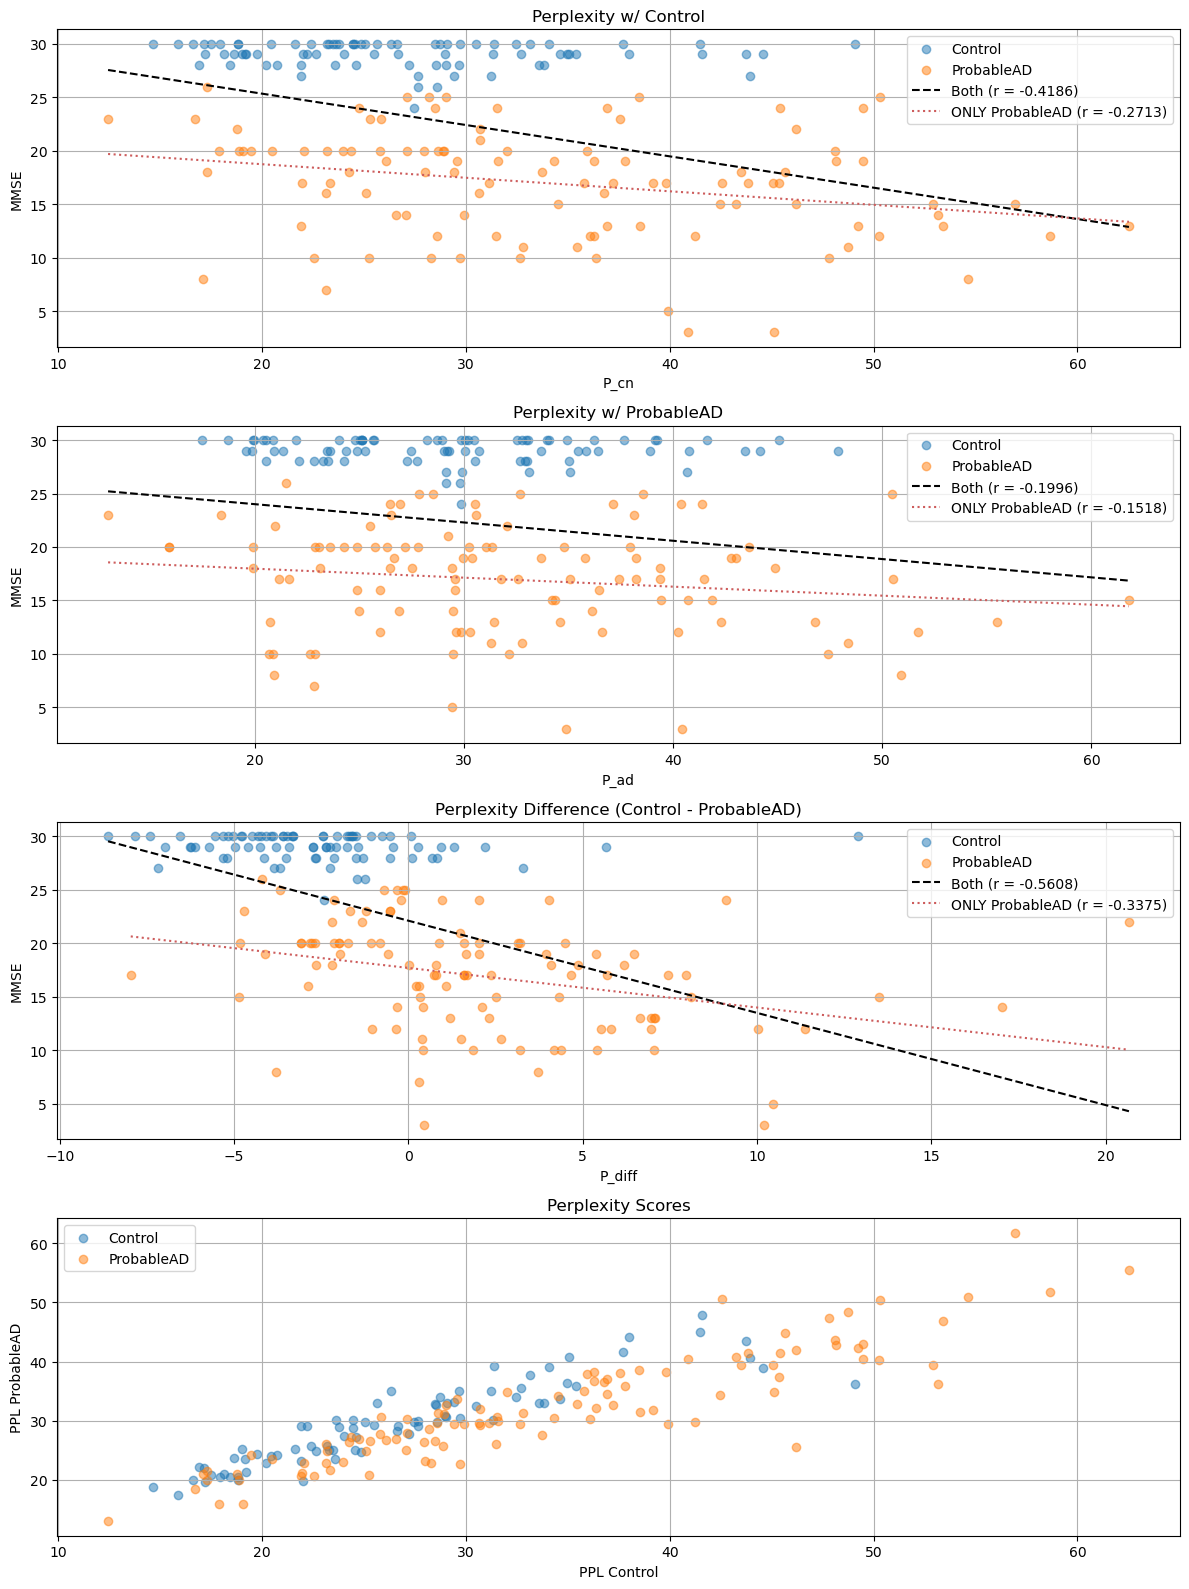

In [16]:
plot_mmse_panels(d0);

---
# Quick dirty t-test code

In [17]:
import numpy as np
import pandas as pd
from itertools import combinations
from scipy import stats

# -----------------------------
# 1) MMSE -> severity bins
# -----------------------------
def mmse_to_severity(mmse: pd.Series) -> pd.Series:
    # Bins: Severe (0–10), Moderate (11–20), Mild (21–26), None (27–30)
    bins   = [-1, 10, 20, 26, 31]
    labels = ["Severe", "Moderate", "Mild", "None"]
    return pd.cut(mmse, bins=bins, labels=labels, right=True)

# -----------------------------
# 2) Stats helpers
# -----------------------------
def welch_p(a, b) -> float:
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    if len(a) < 2 or len(b) < 2: return np.nan
    return float(stats.ttest_ind(a, b, equal_var=False).pvalue)

def hedges_g(a, b) -> float:
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[np.isfinite(a)]; b = b[np.isfinite(b)]
    na, nb = len(a), len(b)
    if na < 2 or nb < 2: return np.nan
    sa2, sb2 = a.var(ddof=1), b.var(ddof=1)
    sp = np.sqrt(((na-1)*sa2 + (nb-1)*sb2) / (na+nb-2))
    if sp == 0: return np.nan
    d = (a.mean() - b.mean()) / sp
    J = 1 - 3/(4*(na+nb)-9) if (na+nb) > 3 else 1.0
    return float(d * J)

def fmt_p(p, alpha=0.05) -> str:
    if not np.isfinite(p): return ""
    return f"{p:.5f}{'*' if p < alpha else ''}"

# -----------------------------
# 3) Build table 
# -----------------------------
def severity_tests_table(
    df: pd.DataFrame,
    biomarker_cols: list[str],
    mmse_col: str = "mmse",
    alpha: float = 0.05
) -> pd.DataFrame:
    df = df.copy()
    df["severity"] = mmse_to_severity(df[mmse_col])

    
    rows = [
        ("Moderate-Severe", (["Moderate"], ["Severe"])),
        ("Mild-Severe",     (["Mild"], ["Severe"])),
        ("Mild-Moderate",   (["Mild"], ["Moderate"])),
        ("None-Severe",     (["None"], ["Severe"])),
        ("Mod/Sev vs Mild/None", (["Moderate","Severe"], ["Mild","None"])),
        ("Mild/Mod/Sev vs None", (["Mild","Moderate","Severe"], ["None"])),
    ]

    out = []
    for row_name, (A, B) in rows:
        row = {"Comparison": row_name}
        for col in biomarker_cols:
            a = df[df["severity"].isin(A)][col].dropna()
            b = df[df["severity"].isin(B)][col].dropna()
            p = welch_p(a, b)
            #row[col] = fmt_p(p, alpha=alpha)
            row[col] = f"{p:.6f}"
        out.append(row)

    return pd.DataFrame(out).set_index("Comparison")

# -----------------------------
# parallel table of effect sizes
# -----------------------------
def severity_effects_table(
    df: pd.DataFrame,
    biomarker_cols: list[str],
    mmse_col: str = "mmse"
) -> pd.DataFrame:
    df = df.copy()
    df["severity"] = mmse_to_severity(df[mmse_col])

    rows = [
        ("Moderate-Severe", (["Moderate"], ["Severe"])),
        ("Mild-Severe",     (["Mild"], ["Severe"])),
        ("Mild-Moderate",   (["Mild"], ["Moderate"])),
        ("None-Severe",     (["None"], ["Severe"])),
        ("Mod/Sev vs Mild/None", (["Moderate","Severe"], ["Mild","None"])),
        ("Mild/Mod/Sev vs None", (["Mild","Moderate","Severe"], ["None"])),
    ]

    out = []
    for row_name, (A, B) in rows:
        row = {"Comparison": row_name}
        for col in biomarker_cols:
            a = df[df["severity"].isin(A)][col].dropna()
            b = df[df["severity"].isin(B)][col].dropna()
            row[col] = hedges_g(a, b)  # signed effect: A - B
        out.append(row)
    return pd.DataFrame(out).set_index("Comparison")


In [18]:
d0 = ppl_df.copy()


biomarkers = ["P_cn","P_ad","P_diff"]

p_table = severity_tests_table(d0, biomarkers, mmse_col="mmse", alpha=0.05)
g_table = severity_effects_table(d0, biomarkers, mmse_col="mmse")

display(p_table)   # p-values with * markers like in the figure
display(g_table)   # Hedges' g (directional)


,P_cn,P_ad,P_diff
Comparison,,,
Moderate-Severe,0.810835,0.439343,0.206795
Mild-Severe,0.357621,0.952685,0.040541
Mild-Moderate,0.081869,0.186383,0.161996
None-Severe,0.037550,0.754044,0.000073
Mod/Sev vs Mild/None,0.000001,0.021736,0.000000
Mild/Mod/Sev vs None,0.000000,0.032042,0.000000


,P_cn,P_ad,P_diff
Comparison,,,
Moderate-Severe,0.073931,0.259532,-0.366736
Mild-Severe,-0.326407,-0.021817,-0.670360
Mild-Moderate,-0.399861,-0.294463,-0.360266
None-Severe,-0.892614,-0.124732,-1.952265
Mod/Sev vs Mild/None,0.743234,0.343319,1.039799
Mild/Mod/Sev vs None,0.743472,0.304536,1.138290
